<a href="https://colab.research.google.com/github/haleema1011/AI_Flood_Warning_Nothern_Pakistan/blob/main/flood_prediction_throughSVR%2C_ANN%2C_Xgboost_without_lagged_features_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**importing important libararies**

In [ ]:
# Re-import the data and process as requested
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt


**uploading data file**

In [ ]:
#load the data
file_path = '/content/drive/MyDrive/kabul_river_met_discharge_data.csv'
data = pd.read_csv(file_path)

**viewing the data**

In [ ]:
data.head(3)

,Date,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
0,2005-01-01,2005.0,1.0,-0.576,-6.148,3.240,86.145,2.161,728.1
1,2005-01-02,2005.0,2.0,-0.795,-6.936,2.980,81.400,1.530,792.0
2,2005-01-03,2005.0,3.0,2.891,-8.300,2.612,68.630,0.015,514.3


**setting the date column as index columnn**

In [ ]:
# Parse the date and set it as the index for time series analysis
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

**creating lag features of discharge column **

In [ ]:
# Function to create lag features for time-series forecasting
'''def create_lag_features(data, target_col, lags=5):
    """Creates lag features for the target column."""
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)
    return df.dropna()'''

In [ ]:
# Add lag features for discharge (target variable)
'''lagged_data = create_lag_features(data, 'discharge m3/s', lags=5)''

In [ ]:
# Select predictors and target after lag feature creation
features_lagged = data.drop(columns=['discharge m3/s'])
target_lagged = data['discharge m3/s']

In [ ]:
target_lagged

,discharge m3/s
Date,
2005-01-01,728.1
2005-01-02,792.0
2005-01-03,514.3
2005-01-04,415.1
2005-01-05,390.6
...,...
2020-12-27,223.2
2020-12-28,249.5
2020-12-29,255.6


**scaling the data**

In [ ]:
# Apply RobustScaler to handle outliers
scaler_features_robust = RobustScaler()
scaler_target_robust = RobustScaler()

features_scaled_robust = scaler_features_robust.fit_transform(features_lagged)
target_scaled_robust = scaler_target_robust.fit_transform(target_lagged.values.reshape(-1, 1))

**dividing the data into train and test sets**

In [ ]:
# Split the robust-scaled data
X_train, X_test, y_train, y_test = train_test_split(features_scaled_robust, target_scaled_robust, test_size=0.2, random_state=42, shuffle = False)

In [ ]:
# prompt: shapes of train test sets

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4675, 7)
Shape of X_test: (1169, 7)
Shape of y_train: (4675, 1)
Shape of y_test: (1169, 1)


In [ ]:


# Find the start date of the test set
test_start_date = data.index[len(X_train)]
print(f"Test set starts from: {test_start_date}")

# Find the highest value in y_test and its corresponding date
highest_ytest_value = scaler_target_robust.inverse_transform(y_test.max().reshape(1, -1))[0,0] # Inverse transform to get original scale
highest_ytest_index = np.argmax(y_test)
date_of_highest = data.index[len(X_train) + highest_ytest_index]

print(f"Highest value in y_test: {highest_ytest_value} on {date_of_highest}")

Test set starts from: 2017-10-20 00:00:00
Highest value in y_test: 4145.0 on 2020-09-02 00:00:00


In [ ]:
#  a svm a model to make prediction rmse, mse, mae, r2

# Train an SVR model
svr = SVR()
svr.fit(X_train, y_train.ravel())

# Make predictions
y_pred = svr.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_pred_original_svm = scaler_target_robust.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target_robust.inverse_transform(y_test)

# Calculate evaluation metrics
rmse_svr = np.sqrt(mean_squared_error(y_test_original, y_pred_original_svm))
mse_svr = mean_squared_error(y_test_original, y_pred_original_svm)
mae_svr = mean_absolute_error(y_test_original, y_pred_original_svm)
r2_svr = r2_score(y_test_original, y_pred_original_svm)

print(f"RMSE_SVR: {rmse_svr}")
print(f"MSE_SVR: {mse_svr}")
print(f"MAE_SVR: {mae_svr}")
print(f"R-squared_SVR: {r2_svr}")

RMSE_SVR: 454.496481639893
MSE_SVR: 206567.05182304158
MAE_SVR: 293.65170618239875
R-squared_SVR: 0.6040495185071859


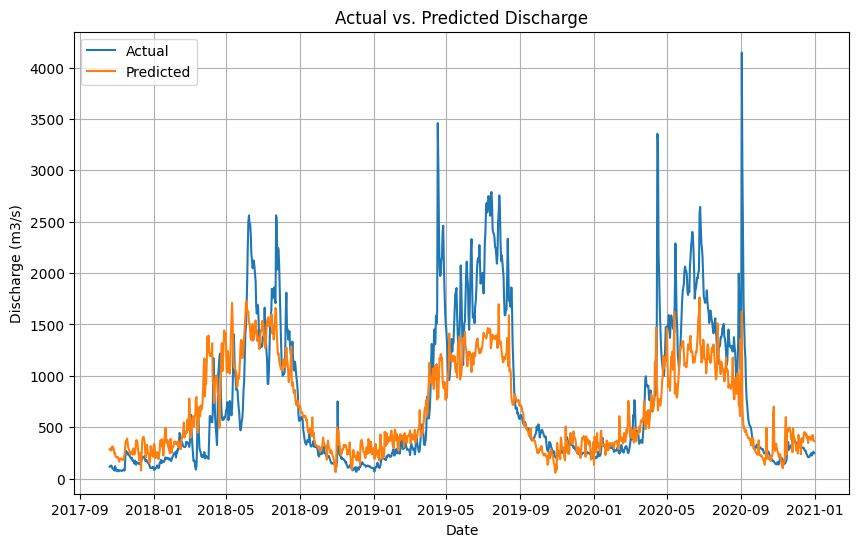

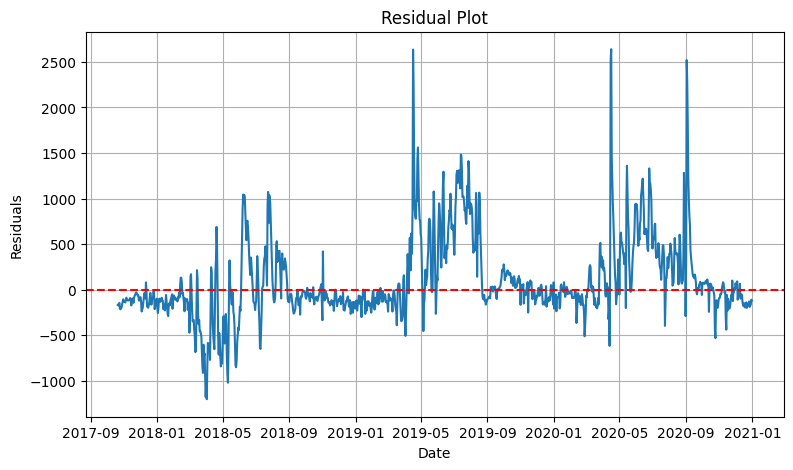

In [ ]:
# the grapgh of actual and predicted and of residuals

import matplotlib.pyplot as plt

# Create the actual vs predicted plot
plt.figure(figsize=(10, 6))
plt.plot(data.index[len(X_train):], y_test_original, label='Actual')
plt.plot(data.index[len(X_train):], y_pred_original_svm, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals
residuals = y_test_original - y_pred_original_svm

# Create the residuals plot
plt.figure(figsize=(9, 5))
plt.plot(data.index[len(X_train):], residuals)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

**XG BOOST**

In [ ]:
#  train a XGBOOST dor prediction

!pip install xgboost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42) # Use reg:squarederror for regression
model.fit(X_train, y_train.ravel())

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_pred_original = scaler_target_robust.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target_robust.inverse_transform(y_test)

# Calculate evaluation metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mse_xgb = mean_squared_error(y_test_original, y_pred_original)
mae_xgb = mean_absolute_error(y_test_original, y_pred_original)
r2_xgb = r2_score(y_test_original, y_pred_original)

print(f"RMSE_xgb: {rmse_xgb}")
print(f"MSE_xgb: {mse_xgb}")
print(f"MAE_xgb: {mae_xgb}")
print(f"R-squared_xgb: {r2_xgb}")

# ... (rest of your plotting code remains the same)

RMSE_xgb: 402.40965655259487
MSE_xgb: 161933.53168677734
MAE_xgb: 248.34367549325177
R-squared_xgb: 0.6896036455216555


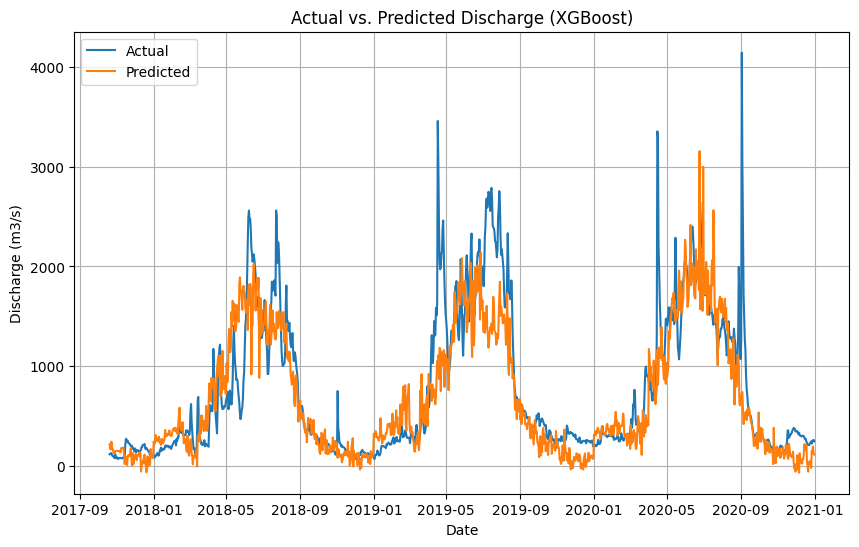

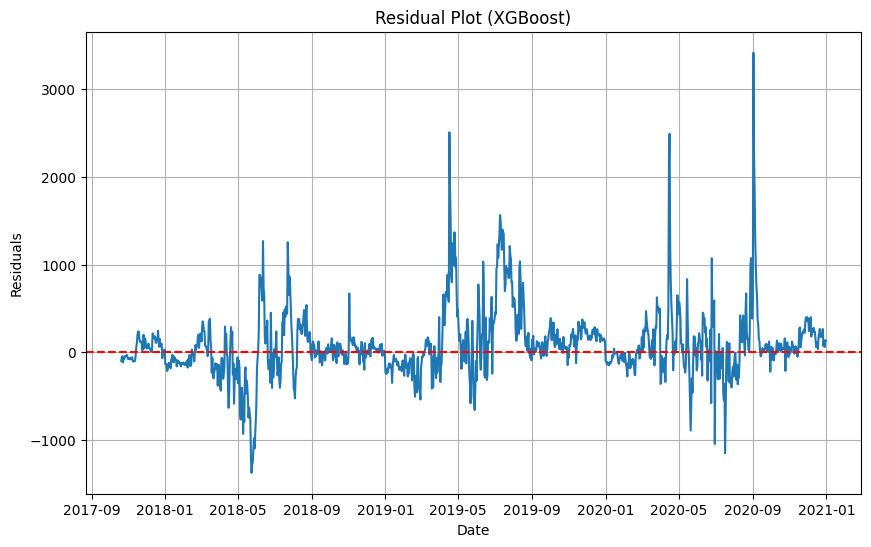

In [ ]:

# Create the actual vs predicted plot for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(data.index[len(X_train):], y_test_original, label='Actual')
plt.plot(data.index[len(X_train):], y_pred_original, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals for XGBoost
residuals_xgb = y_test_original - y_pred_original

# Create the residuals plot for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(data.index[len(X_train):], residuals_xgb)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost)')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [ ]:
!pip uninstall scikit-learn -y
!pip uninstall xgboost -y

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 65.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


ANN(MLP)Regressor

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
!pip install scikit-learn==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.2.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.


In [ ]:
!pip install scikit-learn==0.24.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 39.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Importing necessary modules for ANN
from sklearn.neural_network import MLPRegressor

# Fine-tuning ANN using GridSearchCV
param_grid_ann = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Number of neurons in hidden layers
    'activation': ['relu', 'tanh'],                  # Activation functions
    'solver': ['adam', 'lbfgs'],                      # Solver for weight optimization
    'learning_rate': ['constant', 'adaptive'],        # Learning rate schedule
    'max_iter': [200, 500]                            # Maximum number of iterations
}

# Grid search to find the best hyperparameters for ANN
grid_search_ann = GridSearchCV(MLPRegressor(random_state=42), param_grid_ann, scoring='r2', cv=5, verbose=1)
grid_search_ann.fit(X_train, y_train.ravel())

# Retrieve the best parameters from GridSearchCV
best_params_ann = grid_search_ann.best_params_
print(best_params_ann)

# Evaluate the ANN model with multiple metrics
y_pred_robust_ann = grid_search_ann.best_estimator_.predict(X_test)

# Inverse transform predicted and actual values
y_pred_original_ann = scaler_target_robust.inverse_transform(y_pred_robust_ann.reshape(-1, 1))
y_test_original_ann = scaler_target_robust.inverse_transform(y_test)

# Evaluate performance metrics on the original scale for ANN
mse_original_ann = mean_squared_error(y_test_original_ann, y_pred_original_ann)
rmse_original_ann = np.sqrt(mse_original_ann)
mae_original_ann = mean_absolute_error(y_test_original_ann, y_pred_original_ann)
r2_original_ann = r2_score(y_test_original_ann, y_pred_original_ann)

# Custom Metric: Natche (Nash-Sutcliffe Efficiency) for ANN
natche_original_ann = 1 - (np.sum((y_test_original_ann - y_pred_original_ann) ** 2) /
                           np.sum((y_test_original_ann - np.mean(y_test_original_ann)) ** 2))

# Display results for ANN
mse_original_ann, rmse_original_ann, mae_original_ann, r2_original_ann


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


(134776.4457237945, 367.11911653276036, 230.92441474229076, 0.7416587102964405)

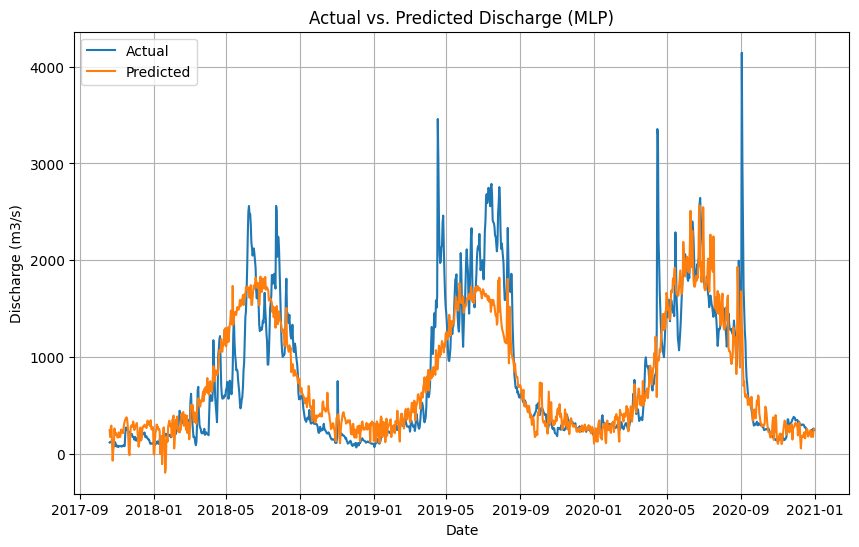

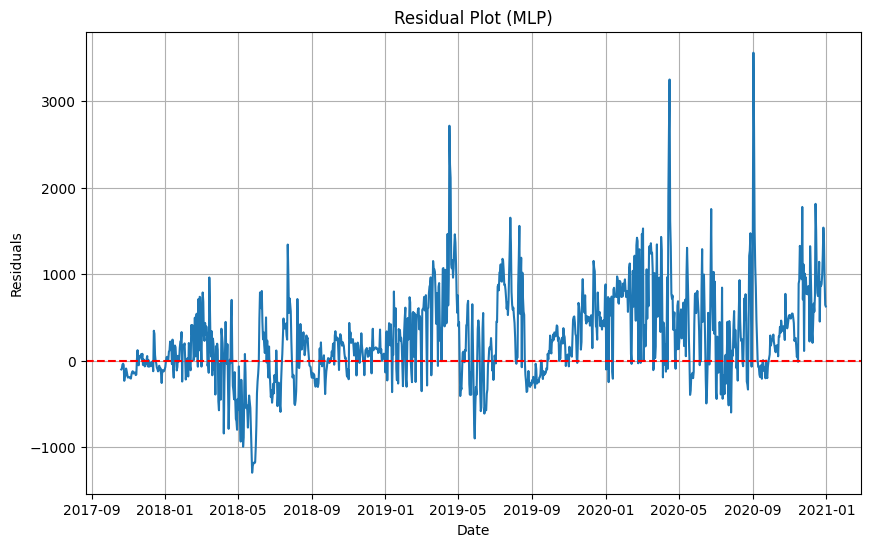

In [ ]:
# Create the actual vs predicted plot for MLP
plt.figure(figsize=(10, 6))
plt.plot(data.index[len(X_train):], y_test_original, label='Actual')
plt.plot(data.index[len(X_train):], y_pred_original_ann, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge (MLP)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals for MLP
residuals_mlp = y_test_original - y_pred_original

# Create the residuals plot for MLP
plt.figure(figsize=(10, 6))
plt.plot(data.index[len(X_train):], residuals_mlp)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual Plot (MLP)')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [ ]:
# make a table of all the results

import pandas as pd

# Create a dictionary to store the results
results = {
    'Model': ['SVR', 'XGBoost', 'MLP', 'MLP (GridSearchCV)'],
    'RMSE': [rmse_svr, rmse_xgb, rmse_ann, rmse_original_ann],
    'MSE': [mse_svr, mse_xgb, mse_ann, mse_original_ann],
    'MAE': [mae_svr, mae_xgb, mae_ann, mae_original_ann],
    'R-squared': [r2_svr, r2_xgb, r2_ann, r2_original_ann]
}



# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)
results_df

,Model,RMSE,MSE,MAE,R-squared
0,SVR,454.496482,206567.051823,293.651706,0.604050
1,XGBoost,402.409657,161933.531687,248.343675,0.689604
2,MLP,580.849294,337385.902672,417.828926,0.353294
3,MLP (GridSearchCV),367.119117,134776.445724,230.924415,0.741659


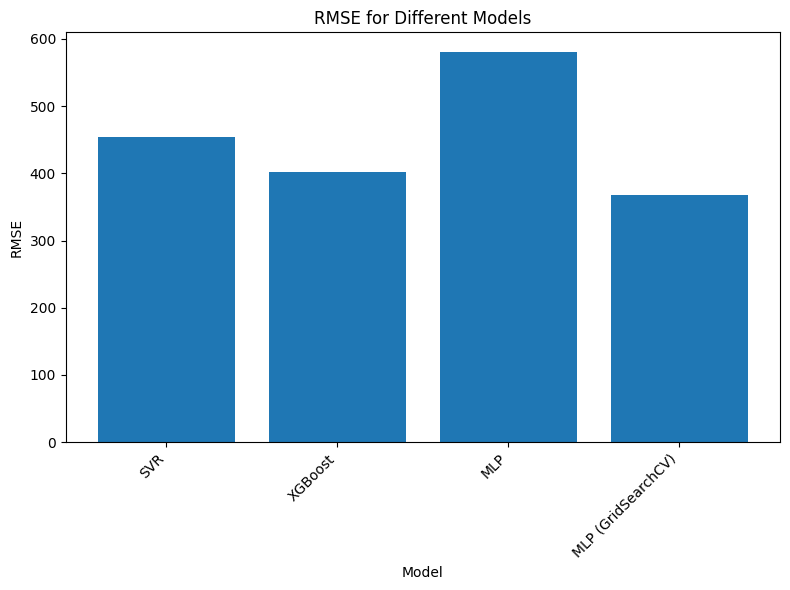

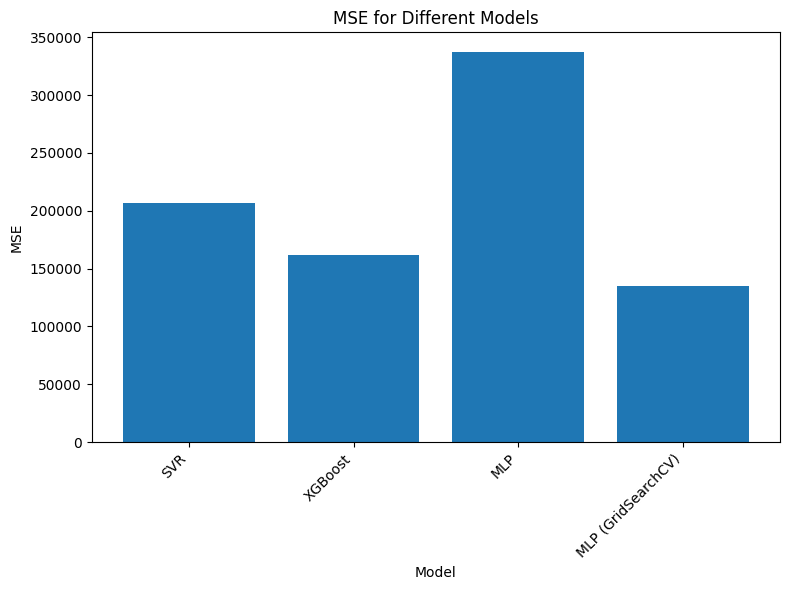

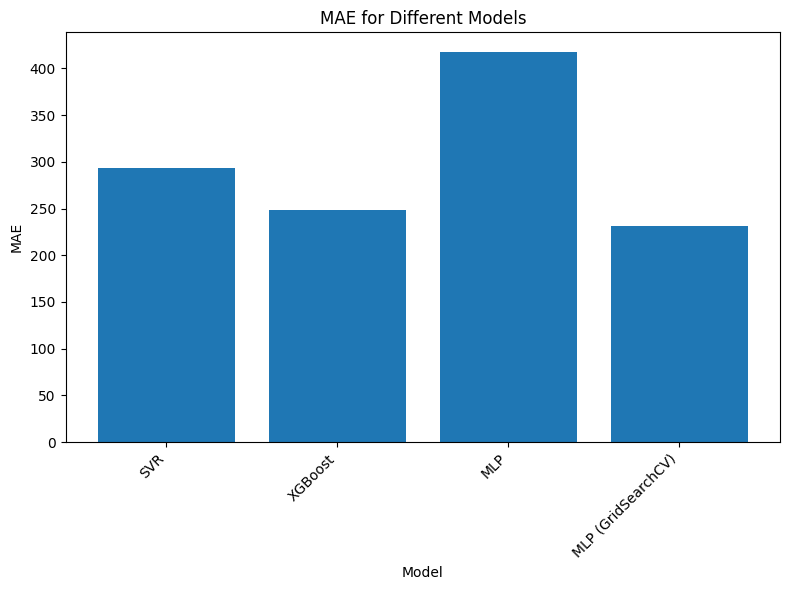

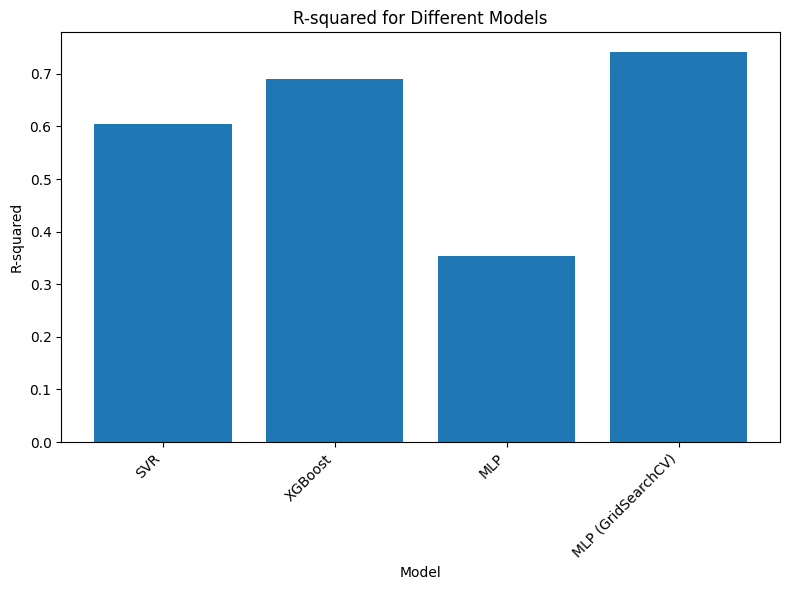

In [ ]:
# chart of results.of each matic create seperate charts

import matplotlib.pyplot as plt

# ... (Your existing code)

# Create a dictionary to store the results
results = {
    'Model': ['SVR', 'XGBoost', 'MLP', 'MLP (GridSearchCV)'],
    'RMSE': [rmse_svr, rmse_xgb, rmse_ann, rmse_original_ann],
    'MSE': [mse_svr, mse_xgb, mse_ann, mse_original_ann],
    'MAE': [mae_svr, mae_xgb, mae_ann, mae_original_ann],
    'R-squared': [r2_svr, r2_xgb, r2_ann, r2_original_ann]
}

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)

# Plotting for each metric

metrics = ['RMSE', 'MSE', 'MAE', 'R-squared']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.bar(results_df['Model'], results_df[metric])
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} for Different Models')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

**COMPARING THE PERFORMANCE OF ML models**

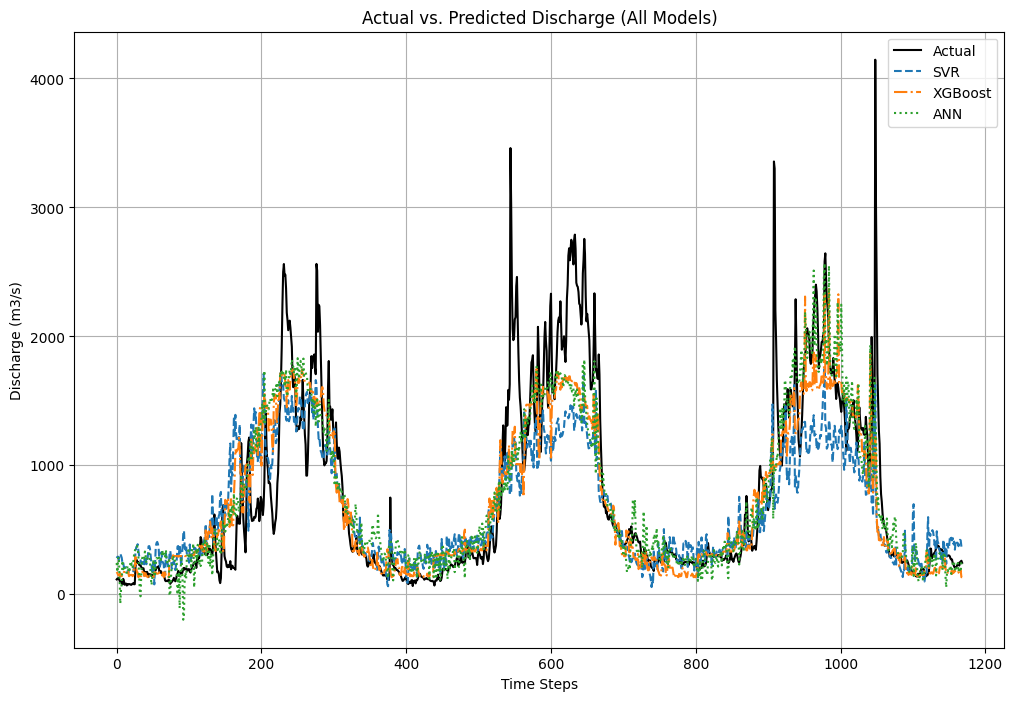

In [ ]:
#grapgh of all model predictions over actual values

import matplotlib.pyplot as plt

# Assuming y_test_original, y_pred_original (for SVR), y_pred_original_xgb (for XGBoost), and y_pred_original_ann (for ANN) are defined.

plt.figure(figsize=(12, 8))

# Plot actual values
plt.plot(y_test_original, label='Actual', color='black')

# Plot predicted values for each model
plt.plot(y_pred_original_svm, label='SVR', linestyle='--')
plt.plot(y_pred_original_xgb, label='XGBoost', linestyle='-.')
plt.plot(y_pred_original_ann, label='ANN', linestyle=':')


plt.xlabel('Time Steps')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge (All Models)')
plt.legend()
plt.grid(True)
plt.show()